In [ ]:
!pip install langdetect


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 56.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=f2d00cc341f5222e5c868515c19ed2e265740a168b168737ccab0e2c98e4d7e5
  Stored in directory: /root/.cache/pip/wheels/c1/67/88/e844b5b022812e15a52e4eaa38a1e709e99f06f6639d7e3ba7
Successfully built langdetect


In [ ]:
# Core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# NLP & ML
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import LatentDirichletAllocation

In [ ]:
# Load Airbnb reviews dataset
df = pd.read_csv("reviews.csv")

print("Shape:", df.shape)
df.head()


Shape: (342904, 6)


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2818.0,1191.0,3/30/2009,10952,Lam,Daniel is really cool. The place was nice and ...
1,515749.0,1671407.0,7/9/2012,2640670,Gregory,If you want the authentic Amsterdam houseboat ...
2,515749.0,1715674.0,7/15/2012,1032804,Michael,Unique and luxurious to be sure. I couldn't re...
3,2818.0,1771.0,4/24/2009,12798,Alice,Daniel is the most amazing host! His place is ...
4,515749.0,1963378.0,8/12/2012,503786,Brian,My wife and I recently stopped in Amsterdam fo...


In [ ]:
# Drop missing reviews
df = df.dropna(subset=["comments"]).copy()

# Convert date column
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date"])

# Clean text
df["comments"] = (
    df["comments"]
    .str.lower()
    .str.replace(r"http\S+|www\S+", "", regex=True)
    .str.replace(r"[^a-z\s]", "", regex=True)
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
)

print("Cleaned Shape:", df.shape)
df.head()


Cleaned Shape: (342888, 6)


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2818.0,1191.0,2009-03-30,10952,Lam,daniel is really cool the place was nice and c...
1,515749.0,1671407.0,2012-07-09,2640670,Gregory,if you want the authentic amsterdam houseboat ...
2,515749.0,1715674.0,2012-07-15,1032804,Michael,unique and luxurious to be sure i couldnt reco...
3,2818.0,1771.0,2009-04-24,12798,Alice,daniel is the most amazing host his place is e...
4,515749.0,1963378.0,2012-08-12,503786,Brian,my wife and i recently stopped in amsterdam fo...


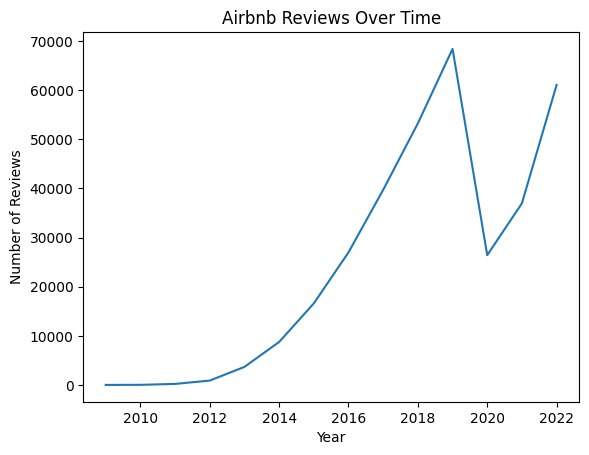

In [ ]:
df["year"] = df["date"].dt.year

reviews_per_year = df.groupby("year").size()

plt.figure()
plt.plot(reviews_per_year.index, reviews_per_year.values)
plt.xlabel("Year")
plt.ylabel("Number of Reviews")
plt.title("Airbnb Reviews Over Time")
plt.show()

In [ ]:
df["review_length"] = df["comments"].apply(lambda x: len(x.split()))

df["review_length"].describe()

,review_length
count,342888.000000
mean,44.233820
std,42.895325
min,0.000000
25%,16.000000
50%,33.000000
75%,59.000000
max,999.000000


In [ ]:
# Count reviews with less than 5 words
short_reviews = df[df["review_length"] < 5].shape[0]

short_reviews


21633

In [ ]:
top_listings = df["listing_id"].value_counts().head(10)

top_listings


,count
listing_id,
50383849.0,1520
32485135.0,1306
45045046.0,1232
40606723.0,1106
35927687.0,1078
802052.0,1022
82482.0,949
785432.0,883
1814121.0,847


In [ ]:
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException

DetectorFactory.seed = 0

def fast_detect_language(text, max_chars=300):
    try:
        return detect(text[:max_chars])
    except LangDetectException:
        return "unknown"

# FAST language detection
df["language"] = df["comments"].apply(fast_detect_language)

df["language"].value_counts().head(10)


,count
language,
en,257160
fr,28505
de,19438
nl,9820
es,9495
it,4560
unknown,3133
pt,1984
ro,1369


In [ ]:
# Keep only English reviews
df = df[df["language"] == "en"].copy()

print("English-only shape:", df.shape)
df["language"].value_counts()


English-only shape: (257160, 9)


,count
language,
en,257160


In [ ]:
positive_words = [
    "great", "amazing", "excellent", "perfect", "love",
    "wonderful", "fantastic", "comfortable", "clean", "friendly"
]

negative_words = [
    "bad", "dirty", "terrible", "worst", "awful",
    "noisy", "broken", "uncomfortable", "rude", "disappointing",
    "small", "expensive", "late", "issue", "problem"
]

def rule_based_sentiment(text):
    pos = sum(word in text for word in positive_words)
    neg = sum(word in text for word in negative_words)

    if pos > neg:
        return "Positive"
    elif neg > pos:
        return "Negative"
    else:
        return "Neutral"

df["sentiment_rule"] = df["comments"].apply(rule_based_sentiment)

df["sentiment_rule"].value_counts(normalize=True) * 100


,proportion
sentiment_rule,
Positive,79.946726
Neutral,17.757038
Negative,2.296236


In [ ]:
# Vectorization
vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
X = vectorizer.fit_transform(df["comments"])

# Weak labels
y = df["sentiment_rule"]

# Train model
model = LogisticRegression(max_iter=1000)
model.fit(X, y)

# Predict sentiment
df["sentiment_ml"] = model.predict(X)

df[["sentiment_rule", "sentiment_ml"]].head()


,sentiment_rule,sentiment_ml
0,Positive,Positive
1,Positive,Positive
2,Positive,Positive
3,Positive,Positive
4,Positive,Positive


In [ ]:
# Reframe sentiment
df["sentiment_binary"] = df["sentiment_ml"].apply(
    lambda x: "Non-Positive" if x != "Positive" else "Positive"
)

df["sentiment_binary"].value_counts(normalize=True) * 100


,proportion
sentiment_binary,
Positive,80.211153
Non-Positive,19.788847


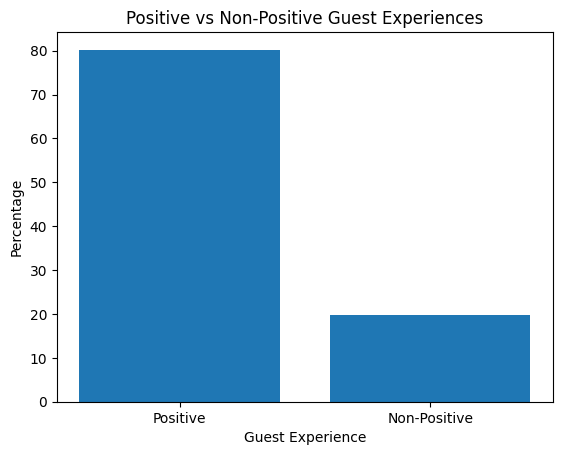

In [ ]:
binary_counts = df["sentiment_binary"].value_counts(normalize=True) * 100

plt.figure()
plt.bar(binary_counts.index, binary_counts.values)
plt.xlabel("Guest Experience")
plt.ylabel("Percentage")
plt.title("Positive vs Non-Positive Guest Experiences")
plt.show()


In [ ]:
sample_df = df.sample(n=40000, random_state=42)

# Count Vectorization (reduced features)
count_vectorizer = CountVectorizer(
    stop_words="english",
    max_features=3000,
    min_df=10
)

X_counts = count_vectorizer.fit_transform(sample_df["comments"])

# LDA using online learning (much faster)
lda = LatentDirichletAllocation(
    n_components=5,
    learning_method="online",
    batch_size=1000,
    random_state=42
)

lda.fit(X_counts)

# Assign topics back to full dataset
full_X_counts = count_vectorizer.transform(df["comments"])
df["topic"] = lda.transform(full_X_counts).argmax(axis=1)

df[["comments", "topic"]].head()


,comments,topic
0,daniel is really cool the place was nice and c...,1
1,if you want the authentic amsterdam houseboat ...,2
2,unique and luxurious to be sure i couldnt reco...,2
3,daniel is the most amazing host his place is e...,2
4,my wife and i recently stopped in amsterdam fo...,2


In [ ]:
feature_names = count_vectorizer.get_feature_names_out()

for idx, topic in enumerate(lda.components_):
    top_words = topic.argsort()[-10:]
    print(f"\nTopic {idx}:")
    print([feature_names[i] for i in top_words])



Topic 0:
['perfect', 'amsterdam', 'clean', 'recommend', 'apartment', 'host', 'place', 'stay', 'location', 'great']

Topic 1:
['stay', 'center', 'house', 'clean', 'city', 'amsterdam', 'good', 'really', 'place', 'nice']

Topic 2:
['airbnb', 'amazing', 'like', 'best', 'time', 'experience', 'place', 'home', 'stay', 'amsterdam']

Topic 3:
['city', 'close', 'place', 'restaurants', 'location', 'stay', 'walk', 'apartment', 'amsterdam', 'great']

Topic 4:
['great', 'good', 'small', 'host', 'kitchen', 'stairs', 'bed', 'bathroom', 'apartment', 'room']


In [ ]:
non_positive_by_topic = (
    df[df["sentiment_binary"] == "Non-Positive"]["topic"]
    .value_counts(normalize=True) * 100
)

non_positive_by_topic


,proportion
topic,
1,32.107135
4,22.987286
0,20.006288
2,13.706302
3,11.192989


In [ ]:
positive_topic_counts = (
    df[df["sentiment_ml"] == "Positive"]["topic"]
    .value_counts()
)

positive_topic_counts


,count
topic,
0,84455
3,41179
1,35403
2,27061
4,18173


In [ ]:
topic_risk_ratio = (
    df.groupby("topic")["sentiment_binary"]
    .value_counts(normalize=True)
    .unstack()
)

topic_risk_ratio


sentiment_binary,Non-Positive,Positive
topic,,
0,0.107581,0.892419
1,0.315778,0.684222
2,0.204930,0.795070
3,0.121515,0.878485
4,0.391617,0.608383


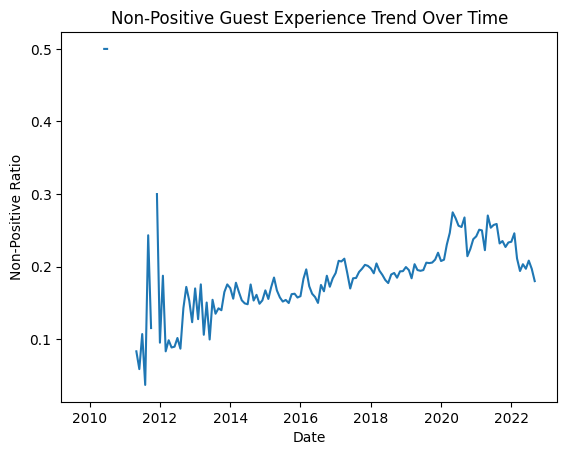

In [ ]:
monthly_risk = (
    df.groupby(df["date"].dt.to_period("M"))["sentiment_binary"]
    .value_counts(normalize=True)
    .unstack()
)

monthly_risk.index = monthly_risk.index.to_timestamp()

plt.figure()
plt.plot(monthly_risk.index, monthly_risk["Non-Positive"])
plt.xlabel("Date")
plt.ylabel("Non-Positive Ratio")
plt.title("Non-Positive Guest Experience Trend Over Time")
plt.show()


In [ ]:
problematic_listings = (
    df[df["sentiment_binary"] == "Non-Positive"]
    .groupby("listing_id")
    .size()
    .sort_values(ascending=False)
    .head(10)
)

problematic_listings


,0
listing_id,
35927687.0,290
50383849.0,261
32485135.0,203
45045046.0,180
82482.0,171
40606723.0,167
35632344.0,150
6133157.0,136
1814121.0,136


In [ ]:
listing_id = 35927687.0  # choose any listing from your output

non_positive_reviews = df[
    (df["listing_id"] == listing_id) &
    (df["sentiment_binary"] == "Non-Positive")
]

non_positive_reviews.shape


(290, 13)

In [ ]:
non_positive_reviews[
    ["date", "comments", "topic", "sentiment_ml"]
].head(5)


,date,comments,topic,sentiment_ml
275033,2019-06-26,thank you will stay again for sure,2,Neutral
275062,2019-07-05,a good placeif you are travelling solo as you ...,2,Neutral
275080,2019-07-07,nice and cozy some problems with checkin but o...,0,Negative
275084,2019-07-12,one of the employees was slightly racist she s...,4,Neutral
275085,2019-07-12,thanks for the stay the surrounding park was b...,3,Neutral


In [ ]:
non_positive_reviews[
    ["date", "comments", "topic", "sentiment_ml"]
].sample(5, random_state=42)


,date,comments,topic,sentiment_ml
275585,2019-10-21,very nice and spacious hostel only problem was...,4,Neutral
276927,2022-04-24,very nice place one of the cleanest hostels iv...,1,Neutral
275332,2019-09-01,dont forget to bring a towel you haveto pay ex...,4,Neutral
276077,2020-08-03,very social good for backpackers finding likem...,4,Neutral
275933,2020-02-11,eggs benedict for breakfast is a must have,4,Neutral


In [ ]:
negative_only = df[
    (df["listing_id"] == listing_id) &
    (df["sentiment_ml"] == "Negative")
]

negative_only[
    ["date", "comments", "topic"]
].sample(5, random_state=42)


,date,comments,topic
276568,2021-11-17,you have to take the boat to get to other plac...,4
275821,2020-01-05,do not come too expensive not flexible not a t...,2
275080,2019-07-07,nice and cozy some problems with checkin but o...,0
275758,2019-12-17,i came to generator amsterdam after a miserabl...,2
276667,2022-03-11,my room had a terrible smell for my whole stay...,4
